### モジュール，データフレームの読み込み

In [1]:
import json
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression

from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split

### 関数の定義

In [2]:
def get_dataframe(cfg: dict) -> pd.DataFrame:
    path = cfg["data_path"]
    df = pd.read_csv(path, index_col=0)

    label_list = []
    for i in range(len(df)):
        tide = df.loc[i, "tide level"]
        if tide > 200.00:
            label_list.append(1)  # 門司港レトロクルーズ
        elif tide > 150.00:
            label_list.append(2)  # 関門海峡クルージング
        elif tide > 100.00:
            label_list.append(3)  # 巌流島上陸
        else:
            label_list.append(4)   # 運行中止

    df["label"] = label_list

    return df


def make_datasets(df: pd.DataFrame, cfg: dict) -> dict:
    pre_df = df.copy().drop(
        [
            "longitude", "calendar", "JMA", "MIRC",
            "rainfall(mm)", "temperature(℃)",
        ],
        axis=1,
    )

    X_cols = []
    y_cols = ["tide level", "label"]
    for i in range(1, 13):
        title = f"tide level shift {i}h"
        X_cols.append(title)
        pre_df[title] = pre_df["tide level"].shift(i)
    X_cols.append("tide level shift 1y")
    pre_df["tide level shift 1y"] = pre_df["tide level"].shift(8570)
    X_cols.append("moon phase")

    pre_df = pre_df.dropna().reset_index().drop("index", axis=1)
    X = pre_df[X_cols]
    y = pre_df[y_cols]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=cfg["split_rate"], random_state=cfg["seed"]
    )

    out = {
        "datasets": pre_df,
        "X": X,
        "X_cols": X_cols,
        "y": y,
        "y_cols": y_cols,
        "X_train": X_train,
        "y_train": y_train,
        "X_test": X_test,
        "y_test": y_test,
    }

    return out


def LRModel(cfg: dict, load_model=False, filename=None, X=None, y=None):
    if load_model:
        loaded_model = pickle.load(open(filename, "rb"))
        return loaded_model

    else:
        model = LinearRegression(
            fit_intercept=bool(cfg["params"]["fit_intercept"]),
            copy_X=bool(cfg["params"]["copy_X"]),
            n_jobs=cfg["params"]["n_jobs"],
            positive=bool(cfg["params"]["positive"]),
        )
        model.fit(X, y)
        return model

### 重回帰分析を行う

In [3]:
filename = "../config/default/LinearRegression.json"
with open(filename) as f:
    cfg = json.load(f)

In [4]:
cfg["data_path"] = "../data/Full_2011-2021/preprocessed_same.csv"
df = get_dataframe(cfg)
out = make_datasets(df, cfg)

In [5]:
model = LRModel(cfg, X=out["X_train"], y=out["y_train"]["tide level"])

In [6]:
y_pred = model.predict(out["X_test"])

pred_df = pd.DataFrame(y_pred, columns=["tide level"])
pred_df.to_csv("../outputs/LinearRegression/2024-05-21/13-29-05/pred.csv")

cfg["data_path"] = "../outputs/LinearRegression/2024-05-21/13-29-05/pred.csv"
pred_df = get_dataframe(cfg)

### 潮位データを用いた評価

#### 残差プロット

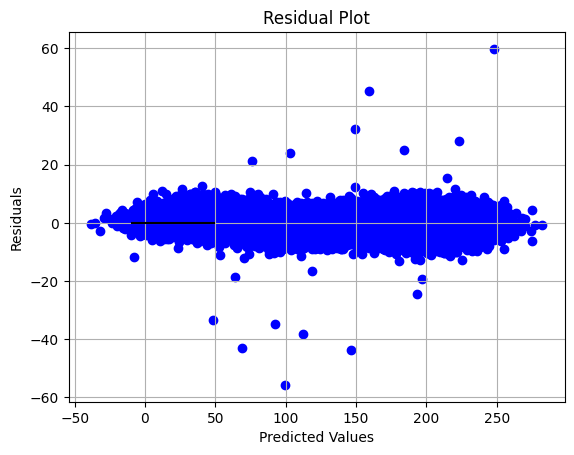

In [7]:
plt.scatter(y_pred, y_pred - out["y_test"]["tide level"], color = 'blue')
plt.hlines(y = 0, xmin = -10, xmax = 50, color = 'black')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid()

plt.show()

上は,潮位のテストデータを用いた予測値と,もとの潮位との残差をプロットしたものである.
残差は,概ね0付近に集まっていることが分かる.

#### MSEおよび決定係数による定量的評価

In [8]:
# 平均二乗誤差(MSE)を求める
y_train_pred = model.predict(out["X_train"])

print('MSE train data: ', mean_squared_error(out["y_train"]["tide level"], y_train_pred))
print('MSE test data: ', mean_squared_error(out["y_test"]["tide level"], y_pred))

MSE train data:  10.81247530950792
MSE test data:  10.691404184698312


In [9]:
# 決定係数を求める
print('r^2 train data: ', r2_score(out["y_train"]["tide level"], y_train_pred))
print('r^2 test data: ', r2_score(out["y_test"]["tide level"], y_pred))

r^2 train data:  0.99670560781792
r^2 test data:  0.9966860152589192


決定係数が1.0に極めて近いため,良いモデルであると言える.さらに,学習用データを用いた場合よりも,テストデータを用いた場合の方が,平均二乗誤差が小さくなったことから,過学習が起きている可能性は低いと考えられる.

### ラベリングを用いた評価

In [11]:
# 分類レポートの作成
label = ["1", "2", "3", "4"]
print(classification_report(out["y_test"]["label"], pred_df["label"],target_names=label))

              precision    recall  f1-score   support

           1       0.93      0.95      0.94      4069
           2       0.95      0.95      0.95      8074
           3       0.96      0.95      0.95      6752
           4       0.98      0.98      0.98      6816

    accuracy                           0.96     25711
   macro avg       0.96      0.96      0.96     25711
weighted avg       0.96      0.96      0.96     25711



精度,再現率,F1スコアのいずれも,1に近い.中でも「ラベル4」の項目では,高い数値を示している.これは,階級の幅が,ラベル1,2,3では50であるのに対し,ラベル4では100であるというところに由来すると考察できる.

以上の各評価より,今回のモデルは良いものであると言える.